In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import os
import sys
import scipy.linalg
import scipy.stats
import importlib

In [3]:
# read in posterior
posterior = numpy.loadtxt ("/Users/steinrue/googleDrive/misc/data_matthias/posterior0.csv")
# load some files maybe
# recombination map (in morgan)
recoMap = numpy.loadtxt ("/Users/steinrue/googleDrive/misc/data_matthias/map.csv", delimiter=',')
print (recoMap.shape)
# readcounts for target individual
# first line: reads for ref; second line: reads for alt
target = numpy.loadtxt ("/Users/steinrue/googleDrive/misc/data_matthias/readcounts.csv", delimiter=',')
print (target.shape)
numSnps = target.shape[1]
# read in references
# 0 in refHaps is refAllele
refHaps = numpy.loadtxt ("/Users/steinrue/googleDrive/misc/data_matthias/refs.csv", delimiter=',')
print (refHaps.shape)
# get some truth
truthTable = pandas.read_csv ("/Users/steinrue/googleDrive/misc/data_matthias/roh_gt.csv", sep='\t')

(38032,)
(2, 38032)
(792, 38032)


In [4]:
# make a truth vector
truth = numpy.zeros (numSnps)
beginnings = numpy.searchsorted (recoMap, truthTable["ROH_Begin"])
ends = numpy.searchsorted (recoMap, truthTable["ROH_End"])
assert (len(beginnings) == len(ends))
for i in range(len(beginnings)):
    truth [beginnings[i]:ends[i]] = 1

#### Old Hapsburg in new place.

In [5]:
# get the path right, for some reason cython makes trouble
sys.path.append("../../Python3/")
sys.path.append("../../Python3/Python3/")
sys.path.append("../../PackagesSupport/loadEigenstrat/")

In [6]:
# load some new stuff
from msFun import old_fwd_bkwd_fast, print_memory_usage
# keep this in the old place
from hmm_inference import HMM_Analyze
from msTransitions import old_calc_transitions
from msEmissions import old_calc_rc_emission_log

In [7]:
# set up all the necessary stuff
n_ref = refHaps.shape[0]

# prepare the recombination map
# fake using a member function of class HMM_Analyze
blub = type('', (), {})()
blub.r_map = recoMap
blub.output = False
r_map = HMM_Analyze.prepare_rmap (self=blub)

# initial probability to copy from one individual
# I guess that means intial prob. for ROH state?
# no, it's actually p(roh) * n_ref
in_val = 1e-4

# transition
# prepare single-step transition (the 3 rates are hardcoded in this)
# t_obj = load_transition_model ("model", n_ref)
# some default params
# t_obj.set_params(roh_in=1, roh_out=10, roh_jump=100)
# t_obj.set_params(roh_in=100, roh_out=100, roh_jump=300)
# this gives only a 3x3 
# t_mat = t_obj.give_transitions()
t_mat = old_calc_transitions (n=n_ref, roh_in=100, roh_out=100, roh_jump=300)
# pre-compute the t_mat at all loci
t_mat_full = HMM_Analyze.pre_compute_transition_matrix (self=None, t=t_mat, r_vec=r_map, n_ref=n_ref)

# emission
# the error rates seem to be somewhat hardcoded, but can be changed
# e_obj = load_emission_model (refHaps, "readcount")
# setattr (e_obj, "e_rate", 1e-2)
# setattr (e_obj, "e_rate_ref", 1e-3)
# prepare the emissions for all loci
# give the reads of the target here
# e_mat = calc_rc_emission_log (ob_stat=target)
e_mat = old_calc_rc_emission_log (ref_haps=refHaps, ob_stat=target, e_rate_ref=1e-3, e_rate=1e-2)
    
# I think we don't need these for now
# n_states = np.shape(e_mat)[0]
# n_loci = np.shape(e_mat)[1]

msPost = old_fwd_bkwd_fast (e_prob0=e_mat, t=t_mat_full, in_val=in_val)
# (post, fwd, bwd, tot_ll) = old_fwd_bkwd_fast (e_mat, t_mat=None, t_mat_full, in_val, full=True)

Reference Number: 792
Memory Usage Full:
Memory Usage: 1362.587648 mB
Total Log likelihood: -18574.356


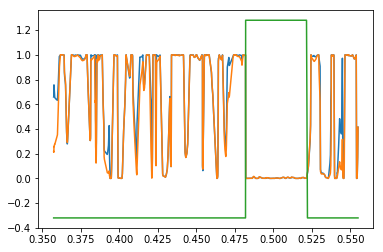

In [8]:
daRange = numpy.arange(5000,8000)
xs = recoMap[daRange]
plt.plot (xs, numpy.exp(posterior[daRange]))
plt.plot (xs, numpy.exp(msPost[0,daRange]))
plt.plot (xs, (truth[daRange]-0.2)*1.6)

#### Try to change up Hapsburg a bit.

In [9]:
# load some new stuff
from msFun import old_fwd_bkwd_fast, print_memory_usage
# keep this in the old place
from hmm_inference import HMM_Analyze, exponentiate_r
from msTransitions import new_calc_transitions
from msEmissions import new_calc_rc_emission_log

In [10]:
# set up all the necessary stuff
n_ref = refHaps.shape[0]

# prepare the recombination map
# fake using a member function of class HMM_Analyze
blub = type('', (), {})()
blub.r_map = recoMap
blub.output = False
r_map = HMM_Analyze.prepare_rmap (self=blub)

# initial probability to copy from one individual
# I guess that means intial prob. for ROH state?
# no, it's actually p(roh) * n_ref
in_val = 1e-4

# transition
# this gives only a 3x3 
# t_mat = old_calc_transitions (n=n_ref, roh_in=100, roh_out=100, roh_jump=300)
# t_mat = new_calc_transitions (roh_in=2.5, roh_out=20, roh_jump=100)
t_mat = new_calc_transitions (roh_in=100, roh_out=100, roh_jump=100)
# pre-compute the t_mat at all loci
# t_mat_full = HMM_Analyze.pre_compute_transition_matrix (self=None, t=t_mat, r_vec=r_map, n_ref=n_ref)
t_mat_full = exponentiate_r (rates=t_mat, rec_v=r_map)
# adjust the matrices here instead of adjusting the fwd/bwd algorithm heavily (yet)
t_mat_full[:,0,1] = (t_mat_full[:,0,1] + t_mat_full[:,0,2])/n_ref
t_mat_full[:,1,2] = t_mat_full[:,1,2]/n_ref

# emission
# prepare the emissions for all loci
e_mat = new_calc_rc_emission_log (ref_haps=refHaps, ob_stat=target, e_rate_ref=1e-3, e_rate=1e-2)
    
# I think we don't need these for now
# n_states = np.shape(e_mat)[0]
# n_loci = np.shape(e_mat)[1]

newPost = old_fwd_bkwd_fast (e_prob0=e_mat, t=t_mat_full, in_val=in_val)
# (post, fwd, bwd, tot_ll) = new_fwd_bkwd_fast (e_mat, t_mat=None, t_mat_full, in_val, full=True)

Memory Usage Full:
Memory Usage: 1607.266304 mB
Total Log likelihood: -18616.310


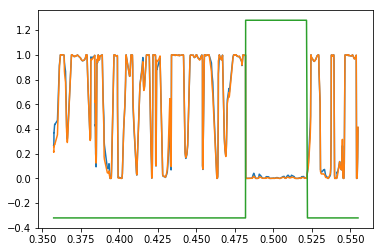

In [11]:
daRange = numpy.arange(5000,8000)
xs = recoMap[daRange]
plt.plot (xs, numpy.exp(newPost[0,daRange]))
plt.plot (xs, numpy.exp(msPost[0,daRange]))
plt.plot (xs, (truth[daRange]-0.2)*1.6)